In [1]:
%pip install numpy pandas scikit-learn tensorflow


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dropout, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

2024-11-14 15:43:41.152057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 15:43:42.004046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 15:43:42.152208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 15:43:43.158517: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 15:43:49.188968: W tensorflow/compiler/tf2

In [3]:
from tensorflow.keras.layers import Bidirectional

In [4]:
# Paths to your data
good_posture_path = "../training_vids/good_posture/csv/"
bad_posture_path = "../training_vids/bad_posture/csv/"

In [5]:
def load_data_with_varying_lengths(path, label):
    data = []
    labels = []

    for file in os.listdir(path):
        if file.endswith(".csv"):
            csv_data = pd.read_csv(os.path.join(path, file))
            data.append(csv_data.values)  # No need to pad/truncate here
            labels.append(label)  # Assign label (0 for bad, 1 for good)

    return data, np.array(labels)

# Combine good and bad data
good_data, good_labels = load_data_with_varying_lengths(good_posture_path, 1)
bad_data, bad_labels = load_data_with_varying_lengths(bad_posture_path, 0)

# Combine good and bad data
data = good_data + bad_data  # List of arrays of varying lengths
labels = np.concatenate((good_labels, bad_labels), axis=0)

In [6]:
X = pad_sequences(data, padding='post', dtype='float32')  # Pad only at the end with zeros

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Build the Bidirectional LSTM model with masking, batch normalization, and L2 regularization
model = Sequential()

# Add masking layer to ignore padded values
model.add(Masking(mask_value=0.0, input_shape=(None, X_train.shape[2])))

# Add Bidirectional LSTM layers with L2 regularization
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.004))))  # Bidirectional LSTM
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.004))))  # Bidirectional LSTM
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add dense layers with L2 regularization
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.004)))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.004)))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping])

Epoch 1/100


/home/dele/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.5594 - loss: 2.6823 - val_accuracy: 0.6136 - val_loss: 2.2464
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6311 - loss: 2.1870 - val_accuracy: 0.5985 - val_loss: 1.9270
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5845 - loss: 1.9234 - val_accuracy: 0.6212 - val_loss: 1.6945
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6466 - loss: 1.6303 - val_accuracy: 0.6212 - val_loss: 1.5356
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5555 - loss: 1.5668 - val_accuracy: 0.6136 - val_loss: 1.4186
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6496 - loss: 1.3912 - val_accuracy: 0.6364 - val_loss: 1.3482
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5887 - loss: 1.3673 - val_accuracy: 0.5758 - val_loss: 1.3200
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5891 - loss: 1.2724 - val_accuracy: 0.5682 - val_

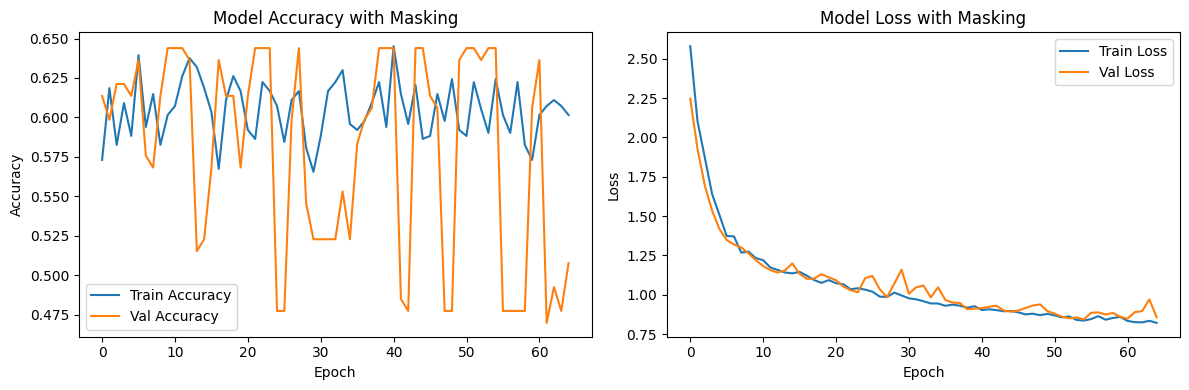

In [24]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy with Masking')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss with Masking')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
#f1 score
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

f1 = f1_score(y_test, y_pred)

print(f"F1 Score: {f1:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
F1 Score: 0.67


In [9]:
from tensorflow.keras.models import load_model

In [10]:
model = load_model('squat_posture_model.h5')

In [18]:
csv_path = '../training_vids/bad_posture/csv/squat_22.csv'

# Preprocess the CSV data (assuming SEQUENCE_LENGTH is the same as used during training)
SEQUENCE_LENGTH = 100  # Replace with your actual sequence length
csv_data = process_csv(csv_path, SEQUENCE_LENGTH)

# Classify the CSV data
prediction = model.predict(csv_data)
print(f'Prediction {prediction}')
# Output the prediction
if prediction >= 0.5:
    print("Good Posture")
else:
    print("Bad Posture")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction [[0.17231913]]
Bad Posture
